In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from shapely import Polygon,Point,MultiPoint,LineString
from scipy.spatial import ConvexHull
from itertools import combinations
from shapely.ops import unary_union
from IPython.display import display, clear_output
from matplotlib import animation
from sympy import symbols
import numpy.matlib
def getPotRegions(X,imp):
    Bx= np.zeros((len(X),4,2));
    for i in range(len(X)):
        Bx[i,0,:]= [X[i][0]-imp, X[i][1]+imp]
        Bx[i,1,:]= [X[i][0]+imp, X[i][1]+imp]
        Bx[i,2,:]= [X[i][0]+imp, X[i][1]-imp]
        Bx[i,3,:]= [X[i][0]-imp, X[i][1]-imp]
    return(Bx);
def getPotRegions_var(X,imp):
    Bx= np.zeros((len(X),4,2));
    for i in range(len(X)):
        Bx[i,0,:]= [X[i][0]-imp[i], X[i][1]+imp[i]]
        Bx[i,1,:]= [X[i][0]+imp[i], X[i][1]+imp[i]]
        Bx[i,2,:]= [X[i][0]+imp[i], X[i][1]-imp[i]]
        Bx[i,3,:]= [X[i][0]-imp[i], X[i][1]-imp[i]]
    return(Bx);
def CPIH_Safepoint(n,Bx,Xi):
    k = int(np.floor(2/3*n)+1);
    n = np.arange(n);

    combk = list(combinations(n,k));
    safeX = [];
    safeY =[];
    first= True;
    CPIH= Polygon();
    #testing
   
    for C in combk:
        if Xi in C:
            comb3 = list(combinations(C,3));
            dp1 =[];
            Chull = Polygon();
            for i in range(len(comb3)):
                comb2 = list(combinations(comb3[i][:],2))
                b1 = int(comb3[i][0]);
                b2 = int(comb3[i][1]);
                b3 = int(comb3[i][2]);
                dp1 = np.vstack((Bx[b1,:,:],Bx[b2,:,:],Bx[b3,:,:]));
                idx = ConvexHull(dp1);
                dp1 = Polygon(dp1[idx.vertices,:]);
                dp2 = Polygon();
                for j in range(len(comb2)):
                    a1 = comb2[j][0];
                    a2 = comb2[j][1];
                    temp= np.vstack((Bx[a1,:,:],Bx[a2,:,:]));
                    idx = ConvexHull(temp);
                    temp =  Polygon(temp[idx.vertices,:]);
                    dp2 = unary_union([dp2,temp])
                diff = dp1.difference(dp2);
                Chull= unary_union([Chull,diff]);


            if (first and not Chull.is_empty):
                CPIH = Polygon(Chull.convex_hull);

            else:
                #NEW 
                if not Chull.is_empty:
                    Chull = Polygon(Chull.convex_hull);
                #ENDNEW
                CPIH = CPIH.intersection(Chull);
                if not CPIH.geom_type == 'Polygon' and not CPIH.is_empty:

                    for member in CPIH.geoms:
                        if member.geom_type == 'Polygon':
                            CPIH = member;


                if CPIH.is_empty:
                    return [0,0];
                    break;
            first = False;
    safeX,safeY = np.array(CPIH.exterior.xy)
        #safeX.append(x);
        #safeY.append(y);
    return [safeX,safeY];
    #return CPIH
def maxDist(Xi,safeX,safeY):
    max_dist = 0;
    max_indx = [];
    for i in range(len(safeX)):
        norm = np.linalg.norm(Xi-[safeX[i],safeY[i]]);
        if norm> max_dist:
            max_dist = norm;
            max_indx = [];
            max_indx.append(i);
        elif norm == max_dist:
            max_indx.append(i);
            
    return [np.mean(safeX[max_indx]),np.mean(safeY[max_indx])],max_dist;
def minOrthProj(Xi,Xj,X):
    JI = Xj-Xi;
    mindist = 100;
    for i in range(len(X)):
        if any(X[i] != Xi) and any(X[i] != Xj):
            AB = X[i]-Xi;
            
            AB_orth = np.array([-AB[1],AB[0]]);
            alt = np.linalg.norm(np.dot(AB_orth,JI)/pow(np.linalg.norm(AB_orth),2)*AB_orth);
            if alt < mindist:
                mindist = alt;
    return mindist;
def ExtractX(lst,i):
    return [item[i][0] for item in lst]
def ExtractY(lst,i):
    return [item[i][1] for item in lst]

def plothull(X):
    hull = ConvexHull(X);
    hullx = np.append(X[hull.vertices,0],X[hull.vertices[0],0]);
    hully = np.append(X[hull.vertices,1],X[hull.vertices[0],1]);
    plt.plot(hullx,hully);
def calcsafepoint(n,Bx):
    n = np.arange(n);
    comb3 = list(combinations(n,3));
    safeX = [];
    safeY =[];
    dp1 =[]
    for i in range(len(comb3)):
        comb2 = list(combinations(comb3[i][:],2))
        b1 = int(comb3[i][0]);
        b2 = int(comb3[i][1]);
        b3 = int(comb3[i][2]);
        dp1 = np.vstack((Bx[b1,:,:],Bx[b2,:,:],Bx[b3,:,:]));
        idx = ConvexHull(dp1);
        dp1 = Polygon(dp1[idx.vertices,:]);
        dp2 = Polygon();
        for j in range(len(comb2)):
            a1 = comb2[j][0];
            a2 = comb2[j][1];
            temp= np.vstack((Bx[a1,:,:],Bx[a2,:,:]));
            idx = ConvexHull(temp);
            temp =  Polygon(temp[idx.vertices,:]);
            dp2 = unary_union([dp2,temp])
        diff = dp1.difference(dp2);
        x,y = np.array(diff.exterior.xy)
        safeX.append(x);
        safeY.append(y);
    return [safeX,safeY];           

In [3]:
def getCenterpoint(n,X,i):
    n = np.arange(n);
    combk = list(combinations(n,5));
    safeX = [];
    safeY =[];
    dp1 =[]
    first = True;
    safeHull = Polygon();
    for comb in combk:
        Xc= np.zeros((5,2));
        j = 0;
        for idx in comb:
            Xc[j,:] = X[idx,:];
            j+=1;
        hullk = ConvexHull(Xc);
         
        dp1 = Polygon(Xc[hullk.vertices,:]);
        if safeHull.is_empty:
            safeHull = dp1;
        try:
            safeHull = safeHull.intersection(dp1);
        except:
            print("could not compute centerpoint for ",X)
            safeHull = safeHull
    safeX,safeY = np.array(safeHull.exterior.xy)
    if safeX == [] or safeY == []:
        safeX = 0
        safeY = 0
    
    
    return [safeX,safeY];    

In [8]:
A1 = np.array(((1,0,2),(0,1,0),(2,0,3)))
print(A1)
A2 = np.array(((1,0,0),(0,1,-4),(0,-4,12)))
A3 = np.array(((1,0,-3),(0,1,-1),(-3,-1,9)))
A1inv = np.linalg.inv(A1)
print(A1inv)
A2inv = np.linalg.inv(A2)
A3inv = np.linalg.inv(A3)
x = symbols('x')
y = symbols('y')
z = symbols('z')
p = np.array((x,y,z))


[[1 0 2]
 [0 1 0]
 [2 0 3]]
[[-3.  0.  2.]
 [ 0.  1.  0.]
 [ 2.  0. -1.]]


In [5]:

Ax1 = np.matmul(A1inv,p)
Ax2 = np.matmul(A2inv,p)
Ax3 = np.matmul(A3inv,p)
Eq1 = np.matmul(p,Ax1)
Eq2 = np.matmul(p,Ax2)
Eq3 = np.matmul(p,Ax3)
print('equation1:', Eq1)
print('equation2: ', Eq2)
print('equation3: ', Eq3)

equation1: x*(-3.0*x + 2.0*z) + 1.0*y**2 + z*(2.0*x - 1.0*z)
equation2:  1.0*x**2 + y*(-3.0*y - 1.0*z) + z*(-1.0*y - 0.25*z)
equation3:  x*(-8.0*x - 3.0*y - 3.0*z) + y*(-3.0*x + 4.44089209850063e-16*y - 1.0*z) + z*(-3.0*x - 1.0*y - 1.0*z)


In [7]:
A2 = np.array(((1,0,-5),(0,1,-4),(-5,-4,37)))
A2inv = np.linalg.inv(A2)
A2x = np.matmul(A2inv,p)
D2 = np.matmul(p,A2x)
print(D2/.0625)

16.0*x*(-5.25*x - 5.0*y - 1.25*z) + 16.0*y*(-5.0*x - 3.0*y - 1.0*z) + 16.0*z*(-1.25*x - 1.0*y - 0.25*z)


In [4]:
def GetMaxImp(agent,Xn):
    comb3list = np.array(list(combinations(Xn,3)));
 
    idx = 0;
    dmax = 1000*np.ones(len(Xn))
    for comb in comb3list:
        dlist = [];
        for pos in comb:
            dlist.append(np.linalg.norm(pos-agent))
            if pos[0] != min(comb[:,0]) and pos[0] != max(comb[:,0]):
                center = pos;
                center_idx = np.where(comb == pos)[0][0]
             
        left = min(comb[:,0])
        right = max(comb[:,0])
        bottom = 0
        if min(comb[:,1])<0:
            bottom = -(min(comb[:,0]))
            
        
        left_idx = np.where(comb ==left)[0][0]
        right_idx = np.where(comb ==right)[0][0]
        dlist[0] = np.linalg.norm(comb[left_idx]-agent)
        dlist[1] =np.linalg.norm(comb[center_idx]-agent)
        dlist[2] = np.linalg.norm(comb[right_idx]-agent)
        dlist = np.array(dlist)
        dlist = dlist/min(dlist)
        centerm = np.array([0,center[1]+bottom]);
        leftm = np.array([left-center[0],comb[left_idx][1]+bottom]);
        rightm = np.array([right-center[0],comb[right_idx][1]+bottom]);
        
        d= getD(dlist,leftm,rightm,centerm)
        
        if d*dlist[0]< dmax[np.where(Xn == comb[left_idx])]:
            
        idx +=1
        
    return comb3list,dlist,d

In [234]:
def GetMaxImp2(agent,Xn):
 
    n = np.arange(len(Xn))
    comb3list = list(combinations(n,3))
    idx = 0;
    dmax = 1000*np.ones(len(Xn))
    dlist= []
    for neighbor in range(len(Xn)):
        dlist.append(np.linalg.norm(Xn[neighbor,:]-agent))
    dlist = np.array(dlist)
    dlist = dlist/min(dlist)
    for idx_comb in comb3list:
        comb = Xn[idx_comb[:],:]
       # dlist = [];
        combdlist = []
        for idx in idx_comb:
            pos = Xn[idx,:]
            #dlist.append(np.linalg.norm(pos-agent))
            if pos[0] != min(comb[:,0]) and pos[0] != max(comb[:,0]):
                center = pos;
                center_idx = np.where(Xn == pos)[0][0]
             
        left = min(comb[:,0])
        right = max(comb[:,0])
        bottom = 0
        
        if min(comb[:,1])<0:
            bottom = -(min(comb[:,0]))
        #CHANGED
        bottom = -min(comb[:,1])   

        
        left_idx = np.where(Xn ==left)[0][0]
        right_idx = np.where(Xn ==right)[0][0]
        leftpoint = Xn[left_idx]
        rightpoint = Xn[right_idx]
        if center[1] ==-bottom:
            leftpoint = np.array([leftpoint[0], -leftpoint[1]])
            rightpoint = np.array([rightpoint[0],-rightpoint[1]])
            center = np.array([center[0],-center[1]])
            bottom = -(min(leftpoint[1],rightpoint[1],center[1]))
      
#         dlist[0] = np.linalg.norm(Xn[left_idx]-agent)
#         dlist[1] =np.linalg.norm(Xn[center_idx]-agent)
#         dlist[2] = np.linalg.norm(Xn[right_idx]-agent)
#         dlist = np.array(dlist)
#         dlist = dlist/min(dlist)
        combdlist = [dlist[left_idx],dlist[center_idx],dlist[right_idx]]
        centerm = np.array([0,center[1]+bottom]);
        leftm = np.array([left-center[0],Xn[left_idx][1]+bottom]);
        rightm = np.array([right-center[0],Xn[right_idx][1]+bottom]);

#         d= getD(dlist,leftm,rightm,centerm)
        
#         if d*dlist[0]< dmax[left_idx]:
#             dmax[left_idx] = d*dlist[0]
#         if d*dlist[1]<dmax[center_idx]:
#             dmax[center_idx] = d*dlist[1]
#         if d*dlist[2]<dmax[right_idx]:
#             dmax[right_idx] = d*dlist[2]
        idxlist = [left_idx,center_idx,right_idx]
        d= getD(combdlist,leftm,centerm,rightm,idxlist)
     
        
        if d*combdlist[0]< dmax[left_idx]:
            dmax[left_idx] = d*combdlist[0]
        if d*combdlist[1]<dmax[center_idx]:
            dmax[center_idx] = d*combdlist[1]
        if d*combdlist[2]<dmax[right_idx]:
            dmax[right_idx] = d*combdlist[2]
            
        idx +=1
    dmin= min(dmax)
    dmax = dlist*dmin
    
    return dmax,dlist

In [225]:
def getD(dlist,left,center,right,idxlist):
        d =0
        alpha = abs(left[0])/(right[0]-left[0])
        c = alpha*dlist[2]+(1-alpha)*dlist[0]
        print('c',c)
       # d_idx = np.where(dlist ==1)[0][0]
        k = dlist[0]/dlist[1]
        u = (-k*c+c)/left[0]
        v = (k*center[1]-left[1])/left[0]
        co1 = u**2*dlist[1]**2
        co2 = 2*u*v*dlist[1]**2
        co3 = v**2*dlist[1]**2+dlist[1]**2-c**2
        co4 = 2*center[1]*c
        co5 = -center[1]**2
        coeff = [co1,co2,co3,co4,co5]
        sol = np.roots(coeff)
        print('roots',idxlist)
        print('left: ',left,'center: ',center,'right: ',right)
        for s in sol:
            print(s)
            if not np.iscomplex(s) and s>0:
                d = s
        return d
        
            

In [198]:
left = np.array([-3,0])
right = np.array([3,0])
center = np.array([0,4])
agent = np.array([0,0])
#d = getD(dlist,left,right,center)
Xm = np.vstack((left,right,center))
dmax,dlist = GetMaxImp2(agent,Xm)
print(dmax)

c 1.0
roots [0, 1, 2]
left:  [-3  0] right:  [3 0] center:  [0 4]
(-11.999999999999998+0j)
(-6.66814253145367+6.029672769268337j)
(-6.66814253145367-6.029672769268337j)
(1.336285062907344+0j)
[1.33628506 1.33628506 1.78171342]
[1.33628506 1.33628506 1.78171342]


C:\Users\85chr\AppData\Local\Temp\ipykernel_32348\3717796674.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  dmax[left_idx] = d*combdlist[0]
C:\Users\85chr\AppData\Local\Temp\ipykernel_32348\3717796674.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  dmax[center_idx] = d*combdlist[1]
C:\Users\85chr\AppData\Local\Temp\ipykernel_32348\3717796674.py:63: ComplexWarning: Casting complex values to real discards the imaginary part
  dmax[right_idx] = d*combdlist[2]


In [3]:
def CPIH_Safepoint2(n,Bx,Xi):
    k = int(np.floor(2/3*n)+1);
    n = np.arange(n);

    combk = list(combinations(n,k));
    safeX = [];
    safeY =[];
    first= True;
    CPIH= Polygon();
    #testing
   
    for C in combk:
        
            comb3 = list(combinations(C,3));
            dp1 =[];
            Chull = Polygon();
            for i in range(len(comb3)):
                comb2 = list(combinations(comb3[i][:],2))
                b1 = int(comb3[i][0]);
                b2 = int(comb3[i][1]);
                b3 = int(comb3[i][2]);
                dp1 = np.vstack((Bx[b1,:,:],Bx[b2,:,:],Bx[b3,:,:]));
                idx = ConvexHull(dp1);
                dp1 = Polygon(dp1[idx.vertices,:]);
                dp2 = Polygon();
                for j in range(len(comb2)):
                    a1 = comb2[j][0];
                    a2 = comb2[j][1];
                    temp= np.vstack((Bx[a1,:,:],Bx[a2,:,:]));
                    idx = ConvexHull(temp);
                    temp =  Polygon(temp[idx.vertices,:]);
                    dp2 = unary_union([dp2,temp])
                diff = dp1.difference(dp2);
                Chull= unary_union([Chull,diff]);


            if (first and not Chull.is_empty):
                CPIH = Polygon(Chull.convex_hull);

            else:
                #NEW 
                if not Chull.is_empty:
                    Chull = Polygon(Chull.convex_hull);
                #ENDNEW
                CPIH = CPIH.intersection(Chull);
                if not CPIH.geom_type == 'Polygon' and not CPIH.is_empty:

                    for member in CPIH.geoms:
                        if member.geom_type == 'Polygon':
                            CPIH = member;


                if CPIH.is_empty:
                    return [0,0];
                    break;
            first = False;
    safeX,safeY = np.array(CPIH.exterior.xy)
        #safeX.append(x);
        #safeY.append(y);
    return [safeX,safeY];
    #return CPIH

In [8]:
k = int(np.floor(2/3*n)+1)
print(k)

5


In [5]:
def minOrthProj2(Xi,Xj,X):
    JI = Xj-Xi;
    mindist = 100;
    for i in range(len(X)):
        if any(X[i] != Xi) and any(X[i] != Xj):
            AB = X[i]-Xi;
            
            AB_orth = np.array([-AB[1],AB[0]]);
            alt = np.linalg.norm(np.dot(AB_orth,JI)/pow(np.linalg.norm(AB_orth),2)*AB_orth);
            if alt < mindist:
                mindist = alt;
    return mindist;

In [3]:
def maintDist(X,agent,imp):
    delta = 2.155*2*imp;
    dx = 0;
    for i in range(len(X)):
        if agent != i and i != len(X)-1:
            norm = np.linalg.norm(X[i]-X[agent]);
            dx+=  ((norm-delta)/norm)*(X[i]-X[agent]);
    return np.array(dx);

In [4]:
def maxDist(Xi,safeX,safeY):
    max_dist = 0;
    max_indx = [];
    for i in range(len(safeX)):
        norm = np.linalg.norm(Xi-[safeX[i],safeY[i]]);
        if norm> max_dist:
            max_dist = norm;
            max_indx = [];
            max_indx.append(i);
        elif norm == max_dist:
            max_indx.append(i);
            
    return [np.mean(safeX[max_indx]),np.mean(safeY[max_indx])],max_dist;

In [9]:
def meansafepoint(safeX,safeY):
    mx =0;
    my = 0;
    count = 0;
    for i in range(len(safeX)):
        if (len(safeX[i]) != 0):
            mx += np.mean(safeX[i]);
            my += np.mean(safeY[i]);
            count+=1;
    mx = mx/count;
    my = my/count;
    return mx,my;



In [58]:
testX = np.array([(0,0), (1,2),(3,0)]);
print(minOrthProj(testX[0],testX[1],testX));

2.0


In [23]:
def getPotRegions_var2(X,imp):
    Bx= np.zeros((len(X),4,2));
    for i in range(len(X)):
        Bx[i,0,:]= [float(X[i][0]-imp[i]), float(X[i][1]+imp[i])]
        Bx[i,1,:]= [float(X[i][0]+imp[i]), float(X[i][1]+imp[i])]
        Bx[i,2,:]= [float(X[i][0]+imp[i]), float(X[i][1]-imp[i])]
        Bx[i,3,:]= [float(X[i][0]-imp[i]), float(X[i][1]-imp[i])]
    return(Bx);

In [22]:
def getAllHulls(X,n,imp1,imp2):
        safepoints = [];
        x = X[n];
        X[n] = x+[imp1,0];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);
        X[n] = x+[-imp1,0];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);
        X[n] = x+[0, imp1];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);        
        X[n] = x+[0,-imp1];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);        
        X[n] = x+[imp1,imp1];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);        
        X[n] = x+[imp1,-imp1];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);        
        X[n] = x+[-imp1,imp1];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);        
        X[n] = x+[-imp1,-imp1];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);
        X[n] = x;
        return safepoints;
    

# CONSTANT IMPRECISION SIMULATION

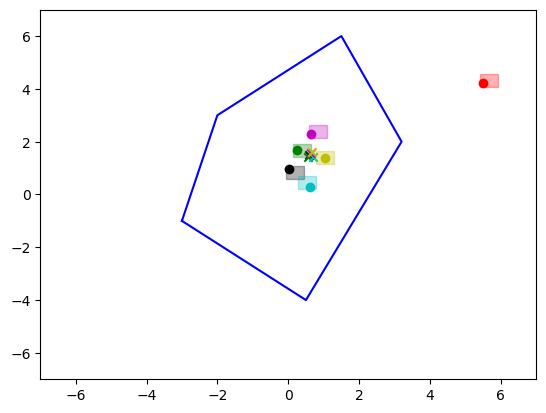

In [13]:
plt.ion();
fig, ax = plt.subplots()
X = np.array([(-3,-1), (-2, 3),(0.5 ,-4),(1.5,6),(3.2,2),(4,-1)]);
#offset = np.ones((6,2))*.5;
#X= 12*(np.random.rand(6,2)-offset)
Xsave = X;
Xn = np.zeros((6,6,2));
Xn[:]= X;
n = len(X);
Xinit = np.array([(-3,-1), (-2, 3),(0.5 ,-4),(1.5,6),(3.2,2),(4,-1)]);
imp = .25;
colors= ['k','g','c','m','y','r'];
empty = False;
frames = [];
step = 0;
emptyCPIH = np.zeros((n,1));
target = np.zeros((n,2));
targetlast = np.zeros((n,2));
targetdist=np.zeros((n,1));
maxdist = 100;
ims = [];
lastCPIH = [[],[],[],[],[]];
temp = [];
#while not empty:
while maxdist >1.27:
    im = [];
    #ax.cla();
    ax.set_xlim(-7,7);
    ax.set_ylim(-7,7);
    dt = .01;
    n = len(X);
    
    safeX= [];
    safeY=[];
    dist = 0;
    for i in range(n):
        Xn[i] = X+2*.25*(np.random.rand(6,2)-.5);
        Xn[i][i]  = X[i];
        if i!= n-1:
            Bx = getPotRegions(Xn[i],imp);

        #if i != n-1 and emptyCPIH[i] == 0:
        if i != n-1:
            safeX,safeY = CPIH_Safepoint2(n,Bx,i);
            #CPIH = CPIH_Safepoint(n,Bx);
            #safeX,safeY = optConfig(Xn[i],i,imp);
            if (isinstance(safeX,int) and isinstance(safeY,int)):
                #print('CPIH empty');
                #empty = True;
                emptyCPIH[i] = 1;
                target[i] = targetlast[i]
            else:
                targetlast[i] = [np.mean(safeX),np.mean(safeY)]; 
                target[i],targetdist[i] = maxDist(X[i],safeX,safeY);
                lastCPIH[i] = [safeX,safeY];
               # emptyCPIH[i] =1;
            
        elif i== n-1:
            target[i] = np.array([(6,6)])
        
    for i in range(n):
        X[i]= X[i]+dt*(target[i]-X[i])#/(np.linalg.norm(X[i]-target[i]))*max((np.linalg.norm(X[i]-target[i])),1);
        if i<n-1:
            dist += np.sqrt(np.dot((target[i]-X[i]),(target[i]-X[i])));
        #X[i]= X[i]+dt*(target[i]);
    if dist< (n-1)*imp*.5 or not any(emptyCPIH[0:4] == 0):
        empty = True;
    artist = ax.fill(safeX,safeY,'b',alpha = 0.3);
    maxdist = np.max(targetdist)
    for j in range(n):
            artist.append(ax.scatter(X[j,0],X[j,1],c = colors[j], marker = 'o'))
            x = Bx[j,:,0];
            y = Bx[j,:,1];
            #ax.scatter(x,y)
            x= np.append(x,Bx[j,0,0])
            y = np.append(y,Bx[j,0,1])
           
            for region in ax.fill(x,y,c = colors[j],alpha  = 0.3):
                artist.append(region)
            if emptyCPIH[j] == 1:
                artist.append(ax.scatter(target[j][0],target[j][1], c = colors[j],marker = 'x'))
    x = np.array([Xinit[0,0],Xinit[1,0], Xinit[3,0], Xinit[4,0], Xinit[2,0],Xinit[0,0]]);
    y = np.array([Xinit[0,1],Xinit[1,1], Xinit[3,1], Xinit[4,1], Xinit[2,1],Xinit[0,1]]);
    for line in ax.plot(x,y,c = 'b'):
        artist.append(line)
    frames.append(artist);
    clear_output(wait = True);
   # fig.canvas.draw()
    #fig.canvas.flush_events();
    #display(fig);
    
    plt.pause(0.1)
    step +=1;
    
#ax.scatter(minimalhull[0],minimalhull[1]);


ani = animation.ArtistAnimation(fig= fig,artists = frames,interval = 50, blit = True);
ani.save('CPIH_Success.gif');
display(fig);




In [12]:
print(maxdist)

1.2631993629671967


C:\Users\85chr\anaconda3\Lib\site-packages\shapely\set_operations.py:419: RuntimeWarning: divide by zero encountered in unary_union
  return lib.unary_union(collections, **kwargs)
C:\Users\85chr\anaconda3\Lib\site-packages\shapely\set_operations.py:131: RuntimeWarning: divide by zero encountered in intersection
  return lib.intersection(a, b, **kwargs)
C:\Users\85chr\anaconda3\Lib\site-packages\shapely\set_operations.py:419: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
C:\Users\85chr\anaconda3\Lib\site-packages\shapely\set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


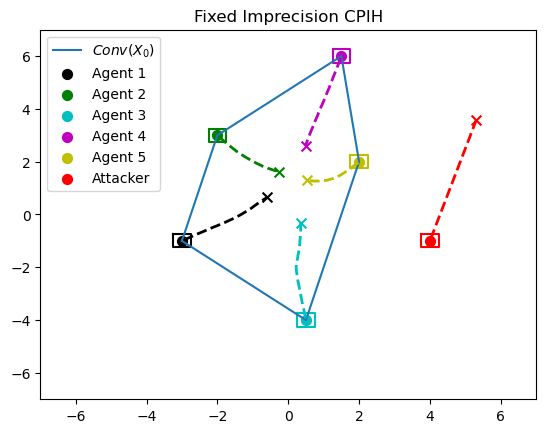

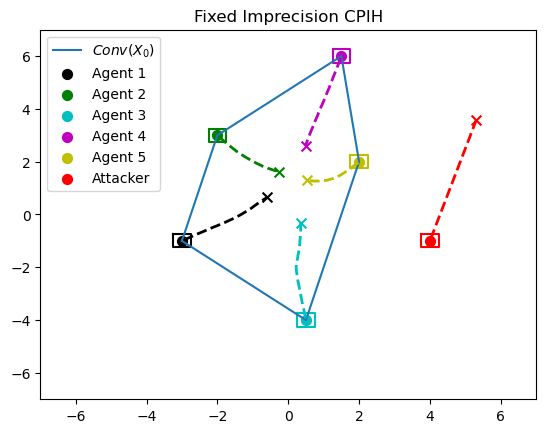

In [6]:

fig, ax = plt.subplots()
X = np.array([(-3,-1), (-2, 3),(0.5 ,-4),(1.5,6),(2,2),(4,-1)]);
offset = np.ones((6,2))*.5;
#X= 12*(np.random.rand(6,2)-offset)
#Xsave = X;
Xn = np.zeros((6,6,2));
Xhist = [];
Yhist = []


Xn[:]= X;
n = len(X);
imp = 0.25;
colors= ['k','g','c','m','y','r'];
empty = False;

step = 0;
emptyCPIH = np.zeros((n,1));
target = np.zeros((n,2));
targetlast = np.zeros((n,2));
targetdist=np.zeros((n,1));
ims = [];
lastCPIH = [[],[],[],[],[]];
temp = [];
#ax.plot(X[0:5,0],X[0:5,1]);
#ax.plot([X[4,0],X[0,0]],[X[4,1],X[0,1]]);
hull = ConvexHull(X[0:5]);
xplot = [];
yplot = [];
Bx = getPotRegions(X,imp);
for j in range(n):
            x = []; y = [];
            for k in range(4):
                x.append(Bx[j,k,0]);
                y.append(Bx[j,k,1]);
            x.append(Bx[j,0,0]);
            y.append(Bx[j,0,1]);
            #ax.scatter(x,y)
            ax.plot(x,y,c= colors[j]);
for v in hull.vertices:
    xplot.append(X[v,0]);
    yplot.append(X[v,1]);
xplot.append(X[hull.vertices[0],0]);
yplot.append(X[hull.vertices[0],1]);
ax.plot(xplot,yplot,label = r'$Conv(X_0)$');
for i in range(5):
    lbl = 'Agent '+str(i+1);
    ax.scatter(X[i,0],X[i,1],c= colors[i], marker = 'o',label = lbl,s =50);
ax.scatter(X[5,0],X[5,1],c= colors[5], marker = 'o',label = 'Attacker',s = 50);
while not empty:
    im = [];
    #ax.cla();
    ax.set_xlim(-7,7);
    ax.set_ylim(-7,7);
    dt = .01;
    n = len(X);
    
    safeX= [];
    safeY=[];
    dist = 0;
    for i in range(n):
        Xn[i] = X+2*.25*(np.random.rand(6,2)-.5);
        Xn[i][i]  = X[i];
        if i!= n-1:
            Bx = getPotRegions(Xn[i],imp);

        #if i != n-1 and emptyCPIH[i] == 0:
        if i != n-1:
            safeX,safeY = CPIH_Safepoint(n,Bx,i);
            #CPIH = CPIH_Safepoint(n,Bx);
            #safeX,safeY = optConfig(Xn[i],i,imp);
            if (isinstance(safeX,int) and isinstance(safeY,int)):
                #print('CPIH empty');
                #empty = True;
                emptyCPIH[i] = 1;
                target[i] = targetlast[i]
            else:
                targetlast[i] = [np.mean(safeX),np.mean(safeY)]; 
                target[i],targetdist[i] = maxDist(X[i],safeX,safeY);
                lastCPIH[i] = [safeX,safeY];
               # emptyCPIH[i] =1;
            
        elif i== n-1:
            target[i] = np.array([(6,6)])
    
    for i in range(n):
        X[i]= X[i]+dt*(target[i]-X[i])/(np.linalg.norm(X[i]-target[i]))*max((np.linalg.norm(X[i]-target[i])),1);
        if i<n-1:
            dist += np.sqrt(np.dot((target[i]-X[i]),(target[i]-X[i])));
        #X[i]= X[i]+dt*(target[i]);
    Xhist.append(X.copy());
    if dist< (n-1)*imp*.5 or not any(emptyCPIH[0:4] == 0):
        empty = True;
    #artist = ax.fill(safeX,safeY,'b',alpha = 0.3);
    
  
            #ax.scatter(x,y)
          
            #if emptyCPIH[j] == 1:
                #artist.append(ax.scatter(target[j][0],target[j][1], c = colors[j],marker = 'x'))
    
    #clear_output(wait = True);
   # fig.canvas.draw()
    #fig.canvas.flush_events();
    #display(fig);
    
    
    step +=1;
Bx = getPotRegions(Xhist[step-1],imp);
for i in range(6):
    xplot = ExtractX(Xhist,i);
    yplot = ExtractY(Xhist,i);
    endn = len(xplot);
    ax.plot(xplot,yplot,c = colors[i],linestyle='dashed',linewidth= 2);
    ax.scatter(xplot[endn-1],yplot[endn-1],c = colors[i], marker='x',s=50);


leg = ax.legend();
plt.title('Fixed Imprecision CPIH');
#ax.scatter(minimalhull[0],minimalhull[1]);
display(fig);
plt.savefig("ApproximateConsensus.jpg")

# Failure in Face of Imprecision

ValueError: zero-size array to reduction operation maximum which has no identity

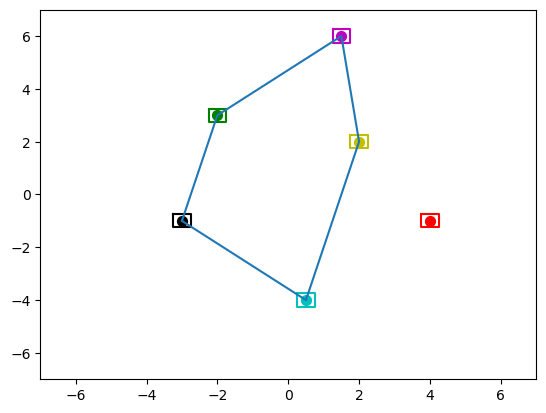

In [19]:

fig, ax = plt.subplots()
X = np.array([(-3,-1), (-2, 3),(0.5 ,-4),(1.5,6),(2,2),(4,-1)]);
offset = np.ones((6,2))*.5;
#X= 12*(np.random.rand(6,2)-offset)
#Xsave = X;
Xn = np.zeros((6,6,2));
Xhist = [];
Yhist = []


Xn[:]= X;
n = len(X);
imp = 0.25;
colors= ['k','g','c','m','y','r'];
empty = False;

step = 0;
emptyCPIH = np.zeros((n,1));
target = np.zeros((n,2));
targetlast = np.zeros((n,2));
targetdist=np.zeros((n,1));
ims = [];
lastCPIH = [[],[],[],[],[]];
temp = [];
#ax.plot(X[0:5,0],X[0:5,1]);
#ax.plot([X[4,0],X[0,0]],[X[4,1],X[0,1]]);
hull = ConvexHull(X[0:5]);
xplot = [];
yplot = [];
Bx = getPotRegions(X,imp);
imp = 0
for j in range(n):
            x = []; y = [];
            for k in range(4):
                x.append(Bx[j,k,0]);
                y.append(Bx[j,k,1]);
            x.append(Bx[j,0,0]);
            y.append(Bx[j,0,1]);
            #ax.scatter(x,y)
            ax.plot(x,y,c= colors[j]);
for v in hull.vertices:
    xplot.append(X[v,0]);
    yplot.append(X[v,1]);
xplot.append(X[hull.vertices[0],0]);
yplot.append(X[hull.vertices[0],1]);
ax.plot(xplot,yplot,label = r'$Conv(X_0)$');
for i in range(5):
    lbl = 'Agent '+str(i+1);
    ax.scatter(X[i,0],X[i,1],c= colors[i], marker = 'o',label = lbl,s =50);
ax.scatter(X[5,0],X[5,1],c= colors[5], marker = 'o',label = 'Attacker',s = 50);
while step<850:
    im = [];
    #ax.cla();
    ax.set_xlim(-7,7);
    ax.set_ylim(-7,7);
    dt = .01;
    n = len(X);
    
    safeX= [];
    safeY=[];
    dist = 0;
    for i in range(n):
        if i <2:
            a = np.array([-imp, imp]);
            Xn[i] = X+np.matlib.repmat(a,6,1);
            Xn[i][n-1]= np.array([-6, 6])
        else:
            a = np.array([imp, imp]);
            Xn[i] = X+np.matlib.repmat(a,6,1);
            Xn[i][n-1]= np.array([6, 6])
        
        
       # if i!= n-1:
           # Bx = getPotRegions(Xn[i],imp);

        #if i != n-1 and emptyCPIH[i] == 0:
        if i != n-1:
            safeX,safeY = getCenterpoint(n,Xn[i],i);
            #CPIH = CPIH_Safepoint(n,Bx);
            #safeX,safeY = optConfig(Xn[i],i,imp);
            if (isinstance(safeX,int) and isinstance(safeY,int)):
                #print('CPIH empty');
                #empty = True;
                emptyCPIH[i] = 1;
                target[i] = targetlast[i]
            else:
                targetlast[i] = [np.mean(safeX),np.mean(safeY)]; 
                if i <2:
                    minval=4;
                    for n in range(len(safeX)):
                        if safeX[n]< minval:
                            minval = safeX[n];
                            minidx = n;
                    target[i] = [np.min(safeX),np.max(safeY)];
                else:
                    maxval = -4;
                    for n in range(len(safeX)):
                        if safeX[n]> maxval:
                            maxval = safeX[n];
                            maxidx=n;
                    target[i] = [np.max(safeX), np.max(safeY)];
                #target[i],targetdist[i] = maxDist(X[i],safeX,safeY);
               
               # emptyCPIH[i] =1;
            
        #elif i== n-1:
        else:   
            target[i] = [6,6];
    
    for i in range(6):
        X[i]= X[i]+dt*.2*(target[i]-X[i]);
        if i  == n-1:
            X[i] = X[i]+dt*.2*([6,6]-X[i]);
        if i<n-1:
            dist += np.sqrt(np.dot((target[i]-X[i]),(target[i]-X[i])));
        #X[i]= X[i]+dt*(target[i]);
    Xhist.append(X.copy());
    if dist< (n-1)*imp*.5 or not any(emptyCPIH[0:4] == 0):
        empty = True;
    #artist = ax.fill(safeX,safeY,'b',alpha = 0.3);
    
  
            #ax.scatter(x,y)
          
            #if emptyCPIH[j] == 1:
                #artist.append(ax.scatter(target[j][0],target[j][1], c = colors[j],marker = 'x'))
    
    #clear_output(wait = True);
   # fig.canvas.draw()
    #fig.canvas.flush_events();
    #display(fig);
    
    
    step +=1;
Bx = getPotRegions(Xhist[step-1],imp);
for i in range(6):
    xplot = ExtractX(Xhist,i);
    yplot = ExtractY(Xhist,i);
    endn = len(xplot);
    ax.plot(xplot,yplot,c = colors[i],linestyle='dashed',linewidth= 2);
    ax.scatter(xplot[endn-1],yplot[endn-1],c = colors[i], marker='x',s=50);


leg = ax.legend();
plt.title('Centerpoint Based Resilient Consensus');
#ax.scatter(minimalhull[0],minimalhull[1]);
display(fig);
plt.savefig("Centerpoint.jpg")

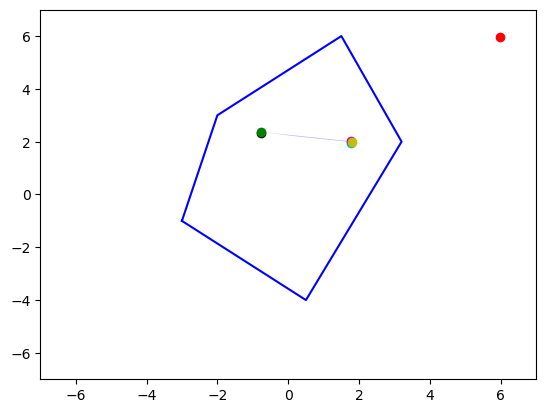

In [22]:
plt.ion();
fig, ax = plt.subplots()
X = np.array([(-3,-1), (-2, 3),(0.5 ,-4),(1.5,6),(3.2,2),(4,-1)]);
Xinit = np.array([(-3,-1), (-2, 3),(0.5 ,-4),(1.5,6),(3.2,2),(4,-1)]);
offset = np.ones((6,2))*.5;
#X= 12*(np.random.rand(6,2)-offset)
Xsave = X;
Xn = np.zeros((6,6,2));
Xn[:]= X;
Xhist = []
n = len(X);
imp = 0;
colors= ['k','g','c','m','y','r'];
empty = False;
frames = [];
step = 0;
lastsafeX = 0
lastsafeY = 0
emptyCPIH = np.zeros((n,1));
target = np.zeros((n,2));
targetlast = np.zeros((n,2));
targetdist=np.zeros((n,1));
ims = [];
lastCPIH = [[],[],[],[],[]];
temp = [];
margin = 0.2;
#while not empty:
while step <500:
    im = [];
    #ax.cla();
    ax.set_xlim(-7,7);
    ax.set_ylim(-7,7);
    dt = .01;
    n = len(X);
    FailX = []
    FailId = []
    safeX= [];
    safeY=[];
    dist = 0;
    for i in range(n):
        Xn[i] = X+2*imp*(np.random.rand(6,2)-.5);
        Xn[i][i]  = X[i];
        if i!= n-1:
            if i<2:
                Xn[i][n-1] = np.array([-6,6]);
            Bx = getPotRegions(Xn[i],imp);
        
        #if i != n-1 and emptyCPIH[i] == 0:
        if i != n-1:
            
                safeX,safeY = getCenterpoint(n,Xn[i],i);
                #CPIH = CPIH_Safepoint(n,Bx);
                #safeX,safeY = optConfig(Xn[i],i,imp);
                if np.all(safeX == 0) and np.all(safeY == 0):
                    emptyCPIH[i] = 1;
                    target[i] = targetlast[i]
                    FailX= Xn[i]
                    FailId = i
                else:
                    lastsafeX = safeX
                    lastsafeY = safeY
                    targetlast[i] = [np.mean(safeX),np.mean(safeY)]; 
                    if i <2:
                        minval=4;
                        for idx in range(len(safeX)):
                            if safeX[idx]< minval:
                                minval = safeX[idx];
                                minidx = idx;
                        try:
                            target[i] = [np.min(safeX)+margin,safeY[minidx]];
                        except:
                            print(str(i)+' has no safeX')
                            print(str(i)+' has no safeY')
                        
                    else:
                        maxval = -4;
                        for idx in range(len(safeX)):
                            if safeX[idx]> maxval:
                                maxval = safeX[idx];
                                maxidx=idx;
                        try:
                            target[i] = [np.max(safeX)-margin, safeY[maxidx]];
                        except:
                            print(str(i)+' has no safeX')
                            print(str(i)+' has no safeY')
        
    if i == n-1:
        target[i] = np.array([(6,6)])
        
    for i in range(n):
        X[i]= X[i]+dt*(target[i]-X[i]);
        if i == n-2:
            Xhist.append(X[i])
       # if i<n-1:
        #    dist += np.sqrt(np.dot((target[i]-X[i]),(target[i]-X[i])));
        #X[i]= X[i]+dt*(target[i]);
    #if dist< (n-1)*imp*.5 or not any(emptyCPIH[0:4] == 0):
    #    empty = True;
    #artist =ax.plot(x,y,'b')
    if np.all(safeX==0) or np.all(safeY == 0):
        artist= ax.fill(lastsafeX,lastsafeY,'b',alpha = 0.3)
     
    else:
        artist = ax.fill(safeX,safeY,'b',alpha = 0.3);
    
    #artist.append(ax.fill(safeX,safeY,'b',alpha=0.3));
    for j in range(n):
            artist.append(ax.scatter(X[j,0],X[j,1],c = colors[j], marker = 'o'))
            x = Bx[j,:,0];
            y = Bx[j,:,1];
            #ax.scatter(x,y)
            x= np.append(x,Bx[j,0,0])
            y = np.append(y,Bx[j,0,1])
           
            for region in ax.fill(x,y,c = colors[j],alpha  = 0.3):
                artist.append(region)
        
            #artist.append(ax.scatter(x,y,c= colors[j]));
           # if emptyCPIH[j] == 1:
            #    artist.append(ax.scatter(target[j][0],target[j][1], c = colors[j],marker = 'x'))
    x = np.array([Xinit[0,0],Xinit[1,0], Xinit[3,0], Xinit[4,0], Xinit[2,0],Xinit[0,0]]);
    y = np.array([Xinit[0,1],Xinit[1,1], Xinit[3,1], Xinit[4,1], Xinit[2,1],Xinit[0,1]]);
    for line in ax.plot(x,y,c = 'b'):
        artist.append(line)
    #artist.append(ax.plot(x,y,c = 'b'))
    
    frames.append(artist);
   
    clear_output(wait = True);
   # fig.canvas.draw()
    #fig.canvas.flush_events();
    #display(fig);
    
    plt.pause(0.3)
    step +=1;
    if step>300:
        margin = 0.4
    
#ax.scatter(minimalhull[0],minimalhull[1]);


ani = animation.ArtistAnimation(fig= fig,artists = frames,interval = 25, blit = False);
ani.save('CPIH_Failure.gif');
display(fig);

In [58]:
    x = np.array([Xinit[0,0],Xinit[1,0], Xinit[3,0], Xinit[4,0], Xinit[2,0],Xinit[0,0]]);
    y = np.array([Xinit[0,1],Xinit[1,1], Xinit[3,1], Xinit[4,1], Xinit[2,1],Xinit[0,1]]);
    print(ax.plot(x,y,'b'))

In [14]:
artist = ax.fill(safeX,safeY,'b',alpha = 0.3);

artist.append(ax.scatter(X[j,0],X[j,1],c = colors[j], marker = 'o'))
            x = Bx[j,:,0];
            y = Bx[j,:,1];
            #ax.scatter(x,y)
            x= np.append(x,Bx[j,0,0])
            y = np.append(y,Bx[j,0,1])
           
            for region in ax.fill(x,y,c = colors[j],alpha  = 0.3):
                artist.append(region)
                
    x = np.array([Xinit[0,0],Xinit[1,0], Xinit[3,0], Xinit[4,0], Xinit[2,0],Xinit[0,0]]);
    y = np.array([Xinit[0,1],Xinit[1,1], Xinit[3,1], Xinit[4,1], Xinit[2,1],Xinit[0,1]]);
    for line in ax.plot(x,y,c = 'b'):
        artist.append(line)

4


# VARIABLE IMPRECISION SIMULATION

C:\Users\85chr\anaconda3\Lib\site-packages\shapely\set_operations.py:419: RuntimeWarning: divide by zero encountered in unary_union
  return lib.unary_union(collections, **kwargs)


NameError: name 'Xinit' is not defined

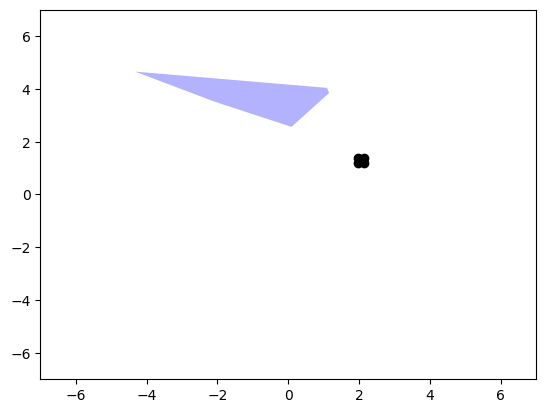

In [28]:
plt.ion();
fig, ax = plt.subplots()
X = np.array([(-3,-1), (-2, 3),(0.5 ,-4),(1.5,6),(1.2,2),(4,-1)]);
offset = np.ones((6,2))*.5;
X= 12*(np.random.rand(6,2)-offset)
Xn = np.zeros((6,6,2));
Xn[:]= X;
n = len(X);
imp = .5*np.ones((6,6))-.5*np.eye(6);
colors= ['k','g','c','m','y','r'];
empty = False;

frames = [];
step = 0;
emptyCPIH = np.zeros((6,1));
hist = [];
for i in range(5):
    hist.append([]);
B2hist = []
target = np.zeros((n,2));
targetdist=np.zeros((n,1));
ims = [];
while not empty:
    im = [];
    #ax.cla();
    ax.set_xlim(-7,7);
    ax.set_ylim(-7,7);
    dt = .01;
    n = len(X);
    
    safeX= [];
    safeY=[];
    dist = 0;
    for i in range(n):
        for j in range(n):
                mindist= minOrthProj(X[i],X[j],X);
                #imp[i][j] = np.linalg.norm(X[i]-X[j])/9;
                imp[i][j] = mindist/3;
                Xn[i][j] = X[j]+2*imp[i][j]*(np.random.rand(1,2)-.5);
        Xn[i][i]  = X[i];
        if i!= n-1:
            Bx = getPotRegions_var(Xn[i],imp[i][:]);

        #if i != n-1 and emptyCPIH[i] == 0:
        if i != n-1:
            safeX,safeY = CPIH_Safepoint(n,Bx,i);
            #CPIH = CPIH_Safepoint(n,Bx);
            #safeX,safeY = optConfig(Xn[i],i,imp);
            if (isinstance(safeX,int) and isinstance(safeY,int)):
                #print('CPIH empty');
                #empty = True;
                hist[i].append(-step);
                emptyCPIH[i] = 1;
                if i == 2:
                    B2hist.append(Bx);
                target[i]= X[i];
            else:
                #target[i] = [np.mean(safeX),np.mean(safeY)];
                target[i],targetdist[i] = maxDist(X[i],safeX,safeY);
                if emptyCPIH[i]:
                    hist[i].append(step);
                    emptyCPIH[i] = 0;
                    
               # emptyCPIH[i] =1;
            
        elif i== n-1:
            target[i] = np.array([(6,6)])
        
    for i in range(n-1):
        X[i]= X[i]+dt*targetdist[i]*(target[i]-X[i]);
        dist += np.sqrt(np.dot((target[i]-X[i]),(target[i]-X[i])));
        #X[i]= X[i]+dt*(target[i]);
    X[n-1] = X[n-1]+dt*target[n-1];
    if step>499 or any(emptyCPIH == 1):
        empty = True;
    artist = ax.fill(safeX,safeY,'b',alpha = 0.3);
    
    for j in range(n):
            x = Bx[j,:,0];
            y = Bx[j,:,1];
            #ax.scatter(x,y)
            artist.append(ax.scatter(x,y,c= colors[j]));
            if emptyCPIH[j] == 1:
                artist.append(ax.scatter(target[j][0],target[j][1], c = colors[j],marker = 'x'))

    frames.append(artist);
    clear_output(wait = True);
   # fig.canvas.draw()
    #fig.canvas.flush_events();
    #display(fig);
    
    plt.pause(0.1)
    step +=1;
    
#ax.scatter(minimalhull[0],minimalhull[1]);


ani = animation.ArtistAnimation(fig= fig,artists = frames,interval = 50, blit = True);
ani.save('CPIH.gif');
display(fig);

# Dynamic Imprecision with New Bound

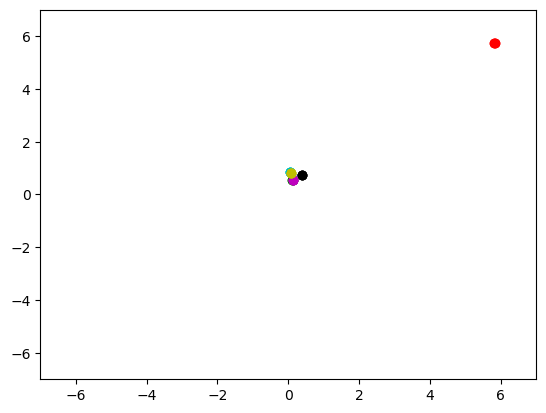

In [264]:
plt.ion();
fig, ax = plt.subplots()
X = np.array([(-3,-1), (-2, 3),(0.5 ,-4),(1.5,6),(1.2,2),(4,-1)]);
offset = np.ones((6,2))*.5;
X= 12*(np.random.rand(6,2)-offset)
Xn = np.zeros((6,6,2));
Xn[:]= X;
n = len(X);
imp = .5*np.ones((6,6))-.5*np.eye(6);
colors= ['k','g','c','m','y','r'];
empty = False;
f_x = []
f_y =[]
frames = [];
step = 0;
emptyCPIH = np.zeros((6,1));
hist = [];
for i in range(5):
    hist.append([]);
fhist = []
maximplist = []
impfail = []
target = np.zeros((n,2));
targetdist=np.zeros((n,1));
ims = [];
ftarget = np.array((6,6));
while not empty:
    im = [];
    #ax.cla();
    ax.set_xlim(-7,7);
    ax.set_ylim(-7,7);
    dt = .01;
    n = len(X);
    
    safeX= [];
    safeY=[];
    dist = 0;
    for i in range(n-1):
        X_N= np.delete(Xn[i],i,0)
        
        max_imp,dlist = GetMaxImp2(X[i],X_N)

        
        max_imp = np.insert(max_imp,i,.0000001)
        if i == 4:
            maximplist.append(max_imp)
        for j in range(n):
            imp[i][j] = max_imp[j]*3/4#*np.sqrt(1/2)*5/6
            Xn[i][j] = X[j]+2*imp[i][j]*(np.random.rand(1,2)-.5);
        Xn[i][i]  = X[i];
        imp[i][i] = 0.00000000001
        if i!= n-1:
            Bx = getPotRegions_var(Xn[i],imp[i][:]);

        #if i != n-1 and emptyCPIH[i] == 0:
        if i != n-1:
           
            #input("Hit Enter")
            safeX,safeY = CPIH_Safepoint(n,Bx,i);
            #CPIH = CPIH_Safepoint(n,Bx);
            #safeX,safeY = optConfig(Xn[i],i,imp);
            if (isinstance(safeX,int) and isinstance(safeY,int)):
                #print('CPIH empty');
                f_x = safeX
                f_y = safeY
                #empty = True;
                hist[i].append(-step);
                Bfail= Bx
                impfail = imp[i]
                dlistfail = dlist
                maximplist.append(max_imp)
                emptyCPIH[i] = 1;
                Xfail = X_N
                
                target[i]= X[i];
            else:
                #target[i] = [np.mean(safeX),np.mean(safeY)];
           
                target[i],targetdist[i] = maxDist(X[i],safeX,safeY);
                if emptyCPIH[i]:
                    hist[i].append(step);
                    emptyCPIH[i] = 0;
                    
               # emptyCPIH[i] =1;
            
        elif i== n-1:
            target[i] = np.array([(6,6)])
            targetdist[i] = 1
        
    for i in range(n-1):
        X[i]= X[i]+dt*targetdist[i]*(target[i]-X[i]);
        dist += np.sqrt(np.dot((target[i]-X[i]),(target[i]-X[i])));
        #X[i]= X[i]+dt*(target[i]);
    X[n-1] = X[n-1]+dt*(ftarget-X[n-1]);
    if step>250 or any(emptyCPIH == 1):
        empty = True;
    artist = ax.fill(safeX,safeY,'b',alpha = 0.3);
    
    for j in range(n):
            x = Bx[j,:,0];
            y = Bx[j,:,1];
            #ax.scatter(x,y)
            artist.append(ax.scatter(x,y,c= colors[j]));
            if emptyCPIH[j] == 1:
                artist.append(ax.scatter(target[j][0],target[j][1], c = colors[j],marker = 'x'))
    frames.append(artist);
    clear_output(wait = True);
   # fig.canvas.draw()
    #fig.canvas.flush_events();
    #display(fig);
    
    plt.pause(0.1)
    step +=1;
    
#ax.scatter(minimalhull[0],minimalhull[1]);


ani = animation.ArtistAnimation(fig= fig,artists = frames,interval = 50, blit = True);
ani.save('CPIH.gif');
display(fig);

In [267]:
print(step)

252


In [ ]:
##### fig, ax = plt.subplots()
X = np.array([(-3,-1), (-2, 3),(0.5 ,-4),(1.5,6),(2,2),(4,-1)]);
offset = np.ones((6,2))*.5;
#X= 12*(np.random.rand(6,2)-offset)
Xn = np.zeros((6,6,2));
Xn[:]= X;
n = len(X);
imp = .5*np.ones((6,6))-.5*np.eye(6);
colors= ['k','g','c','m','y','r'];
empty = False;

frames = [];
step = 0;
emptyCPIH = np.zeros((6,1));
Xhist = [];
Yhist = [];
hull = ConvexHull(X[0:5]);
xplot = [];
yplot = [];

for v in hull.vertices:
    xplot.append(X[v,0]);
    yplot.append(X[v,1]);
xplot.append(X[hull.vertices[0],0]);
yplot.append(X[hull.vertices[0],1]);
ax.plot(xplot,yplot,label = r'$Conv(X_0)$');
for i in range(5):
    lbl = 'Agent '+str(i+1);
    ax.scatter(X[i,0],X[i,1],c= colors[i], marker = 'o',label = lbl,s =50);
ax.scatter(X[5,0],X[5,1],c= colors[5], marker = 'o',label = 'Attacker',s = 50);

target = np.zeros((n,2));
targetdist=np.zeros((n,1));

while not empty:
   
    #ax.cla();
   # ax.set_xlim(-7,7);
   # ax.set_ylim(-7,7);
    dt = .01;
    n = len(X);
    
    safeX= [];
    safeY=[];
    dist = 0;
    for i in range(n):
        for j in range(n):
                mindist= minOrthProj(X[i],X[j],X);
                #imp[i][j] = np.linalg.norm(X[i]-X[j])/9;
                imp[i][j] = mindist/(np.sqrt(2)*3);
                #imp[i][j] = mindist/(6);
                Xn[i][j] = X[j]+2*imp[i][j]*(np.random.rand(1,2)-.5);
        Xn[i][i]  = X[i];
        if i!= n-1:
            Bx = getPotRegions_var(Xn[i],imp[i][:]);
        if step == 0 and i == n-2:          
                minplotvar1 =100;
                for l in range(n):
                    if l != 0:
                        plotvar1 = minOrthProj(X[0],X[l],X);
                    if plotvar1< minplotvar1:
                        minplotvar1 = plotvar1;
                impplot = imp.copy();
                impplot[0][0] =  minplotvar1/3;
                Bxplot = getPotRegions_var(X,impplot[0][:])    
                
                for l in range(n):
                    x = []; y = [];
                    for k in range(4):
                        x.append(Bxplot[l,k,0]);
                        y.append(Bxplot[l,k,1]);
                    x.append(Bxplot[l,0,0]);
                    y.append(Bxplot[l,0,1]);
                    ax.plot(x,y,c= colors[l]);
        #if i != n-1 and emptyCPIH[i] == 0:
        if i != n-1:
            safeX,safeY = CPIH_Safepoint(n,Bx,i);
            #CPIH = CPIH_Safepoint(n,Bx);
            #safeX,safeY = optConfig(Xn[i],i,imp);
            if (isinstance(safeX,int) and isinstance(safeY,int)):
                #print('CPIH empty');
                #empty = True;
                
                emptyCPIH[i] = 1;
                target[i]= X[i];
            else:
                #target[i] = [np.mean(safeX),np.mean(safeY)];
                target[i],targetdist[i] = maxDist(X[i],safeX,safeY);
                
                if emptyCPIH[i]:
                    hist[i].append(step);
                    emptyCPIH[i] = 0;
                    
               # emptyCPIH[i] =1;
            
        elif i== n-1:
            target[i] = np.array([(6,6)])
       
                
        
    for i in range(n-1):
        #X[i]= X[i]+dt*targetdist[i]*(target[i]-X[i]);
        X[i]= X[i]+dt*(target[i]-X[i]);

        #X[i]= X[i]+dt*(target[i]);
    Xhist.append(X.copy());
    X[n-1] = X[n-1]+dt*(target[n-1]-X[n-1]);
    
    
    if step>600 or any(emptyCPIH == 1):
        empty = True;
   # fig.canvas.draw()
    #fig.canvas.flush_events();
    #display(fig);
    step +=1;
    
#ax.scatter(minimalhull[0],minimalhull[1]);

for i in range(6):
    xplot = ExtractX(Xhist,i);
    yplot = ExtractY(Xhist,i);
    endn = len(xplot);
    ax.plot(xplot,yplot,c = colors[i],linestyle='dashed',linewidth= 2);
    ax.scatter(xplot[endn-1],yplot[endn-1],c = colors[i], marker='x',s=50);
ax.set_xlim(-7,7);
ax.set_ylim(-7,7);

leg = ax.legend();
plt.title('Variable Imprecision CPIH');
#ax.scatter(minimalhull[0],minimalhull[1]);
display(fig);
plt.savefig("VariableImprecision.jpg")

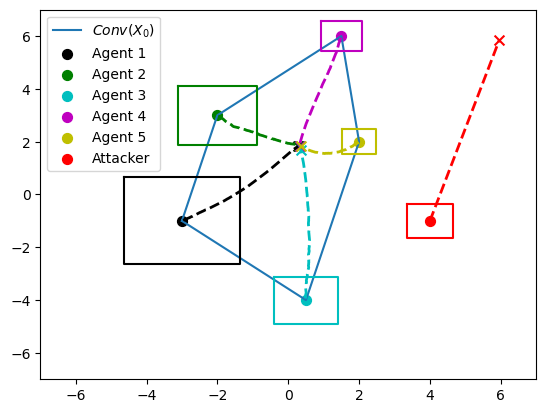

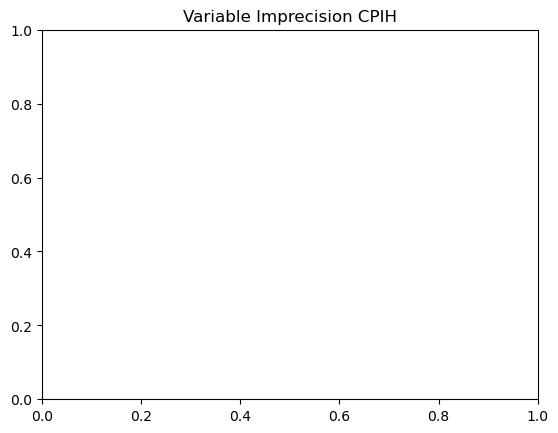

In [23]:

for i in range(6):
    xplot = ExtractX(Xhist,i);
    yplot = ExtractY(Xhist,i);
    endn = len(xplot);
    ax.plot(xplot,yplot,c = colors[i],linestyle='dashed',linewidth= 2);
    ax.scatter(xplot[endn-1],yplot[endn-1],c = colors[i], marker='x',s=50);
ax.set_xlim(-7,7);
ax.set_ylim(-7,7);

leg = ax.legend();
plt.title('Variable Imprecision CPIH');
#ax.scatter(minimalhull[0],minimalhull[1]);
display(fig);
plt.savefig("VariableImprecision.jpg")


4.123105625617661
0
2.7735009811261464
1
2.232625222605753
2
1.4552137502179983
3
[[0.30702116]
 [0.32686023]
 [0.21107926]
 [0.20611565]
 [0.34299717]
 [0.20611565]]
[[0.30702116]
 [0.31148286]
 [0.21107926]
 [0.20611565]
 [0.34299717]
 [0.20611565]]
[[0.30702116]
 [0.31148286]
 [0.2087542 ]
 [0.20611565]
 [0.34299717]
 [0.20611565]]
[[0.30702116]
 [0.31148286]
 [0.2087542 ]
 [0.2087542 ]
 [0.34299717]
 [0.20611565]]
[[0.30702116]
 [0.31148286]
 [0.2087542 ]
 [0.2087542 ]
 [0.33976792]
 [0.20611565]]
[[0.30702116]
 [0.31148286]
 [0.2087542 ]
 [0.2087542 ]
 [0.33976792]
 [0.21459698]]


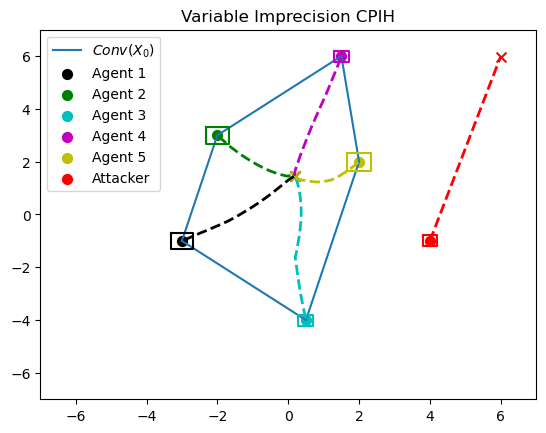

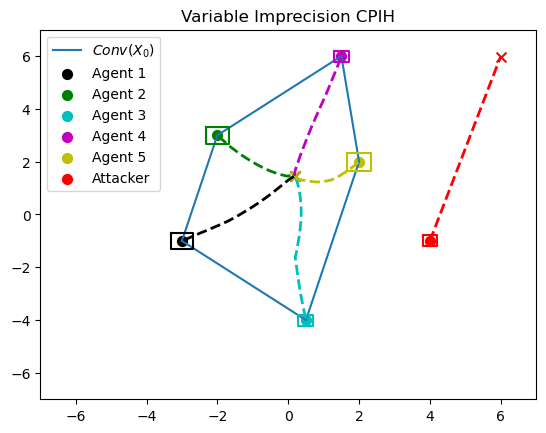

In [34]:

fig, ax = plt.subplots()
X = np.array([(-3,-1), (-2, 3),(0.5 ,-4),(1.5,6),(2,2),(4,-1)]);
offset = np.ones((6,2))*.5;
#X= 12*(np.random.rand(6,2)-offset)
Xn = np.zeros((6,6,2));
Xn[:]= X;
n = len(X);
imp = .5*np.ones((6,6))-.5*np.eye(6);
colors= ['k','g','c','m','y','r'];
empty = False;

frames = [];
step = 0;
emptyCPIH = np.zeros((6,1));
Xhist = [];
Yhist = [];
hull = ConvexHull(X[0:5]);
xplot = [];
yplot = [];
imp2 = .5*np.ones((6,1));
for v in hull.vertices:
    xplot.append(X[v,0]);
    yplot.append(X[v,1]);
xplot.append(X[hull.vertices[0],0]);
yplot.append(X[hull.vertices[0],1]);
ax.plot(xplot,yplot,label = r'$Conv(X_0)$');
for i in range(5):
    lbl = 'Agent '+str(i+1);
    ax.scatter(X[i,0],X[i,1],c= colors[i], marker = 'o',label = lbl,s =50);
ax.scatter(X[5,0],X[5,1],c= colors[5], marker = 'o',label = 'Attacker',s = 50);

target = np.zeros((n,2));
targetdist=np.zeros((n,1));

while not empty:
   
    #ax.cla();
   # ax.set_xlim(-7,7);
   # ax.set_ylim(-7,7);
    dt = .01;
    n = len(X);
    
    safeX= [];
    safeY=[];
    dist = 0;
    for i in range(n):
        mindist = 100;
        for j in range(n):
            if j != i:
                temp_mindist = minOrthProj(X[i],X[j],X);
                if temp_mindist<mindist:
                    mindist = temp_mindist;
        imp2[i] = mindist/(np.sqrt(2)*3);
        if step ==1: 
            print(imp2);
    for i in range(n):
        for j in range(n):
                #mindist= minOrthProj(X[i],X[j],X);
                #imp[i][j] = np.linalg.norm(X[i]-X[j])/9;
                #imp[i][j] = mindist/(np.sqrt(2)*3);
                Xn[i][j] = X[j]+2*imp2[j]*(np.random.rand(1,2)-.5);
        Xn[i][i]  = X[i];
        if i!= n-1:
            Bx = getPotRegions_var2(Xn[i],imp2);
        if step == 0 and i == n-2:          
                minplotvar1 =100;
                for l in range(n):
                    if l != 4:
                        plotvar1 = minOrthProj(X[n-2],X[l],X);
                    if plotvar1< minplotvar1:
                        print(plotvar1);
                        print(l);
                        minplotvar1 = plotvar1;
                impplot = imp2.copy();
                #impplot[n-2][n-2] =  minplotvar1/3;
                Bxplot = getPotRegions_var2(X,impplot)    
                
                for l in range(n):
                    x = []; y = [];
                    for k in range(4):
                        x.append(Bxplot[l,k,0]);
                        y.append(Bxplot[l,k,1]);
                    x.append(Bxplot[l,0,0]);
                    y.append(Bxplot[l,0,1]);
                    ax.plot(x,y,c= colors[l]);
        #if i != n-1 and emptyCPIH[i] == 0:
        if i != n-1:
            safeX,safeY = CPIH_Safepoint2(n,Bx,i);
            #CPIH = CPIH_Safepoint(n,Bx);
            #safeX,safeY = optConfig(Xn[i],i,imp);
            if (isinstance(safeX,int) and isinstance(safeY,int)):
                #print('CPIH empty');
                #empty = True;
                hist[i].append(-step);
                emptyCPIH[i] = 1;
                if i == 2:
                    B2hist.append(Bx);
                target[i]= X[i];
            else:
                #target[i] = [np.mean(safeX),np.mean(safeY)];
                target[i],targetdist[i] = maxDist(X[i],safeX,safeY);
                
                if emptyCPIH[i]:
                    hist[i].append(step);
                    emptyCPIH[i] = 0;
                    
               # emptyCPIH[i] =1;
            
        elif i== n-1:
            target[i] = np.array([(6,6)])
       
                
        
    for i in range(n-1):
        #X[i]= X[i]+dt*targetdist[i]*(target[i]-X[i]);
        X[i]= X[i]+dt*(target[i]-X[i]);

        #X[i]= X[i]+dt*(target[i]);
    Xhist.append(X.copy());
    X[n-1] = X[n-1]+dt*(target[n-1]-X[n-1]);
    
    
    if step>600 or any(emptyCPIH == 1):
        empty = True;
   # fig.canvas.draw()
    #fig.canvas.flush_events();
    #display(fig);
    step +=1;
    
#ax.scatter(minimalhull[0],minimalhull[1]);

for i in range(6):
    xplot = ExtractX(Xhist,i);
    yplot = ExtractY(Xhist,i);
    endn = len(xplot);
    ax.plot(xplot,yplot,c = colors[i],linestyle='dashed',linewidth= 2);
    ax.scatter(xplot[endn-1],yplot[endn-1],c = colors[i], marker='x',s=50);
ax.set_xlim(-7,7);
ax.set_ylim(-7,7);

leg = ax.legend();
plt.title('Variable Imprecision CPIH');
#ax.scatter(minimalhull[0],minimalhull[1]);
display(fig);
plt.savefig("VariableImprecision.jpg")

# Live Simulation

In [31]:
print(imp2)

[[8.07749486e-05]
 [7.92274363e-05]
 [4.28187610e-05]
 [4.28187610e-05]
 [4.91036627e-05]
 [8.07749486e-05]]


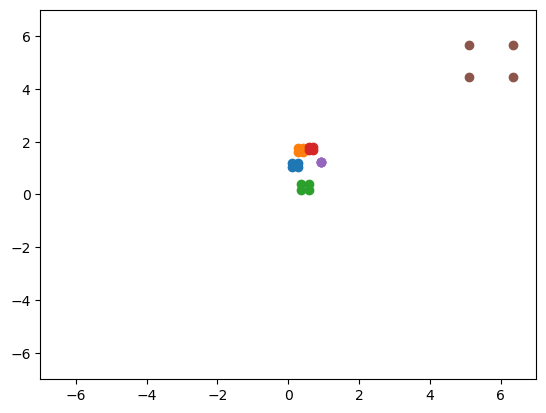

In [13]:
plt.ion();
fig, ax = plt.subplots();
X = np.array([(-3,-1), (-2, 3),(0.5 ,-4),(1.5,6),(3.2,2),(4,-1)]);
Xn = np.zeros((6,6,2));
Xn[:]= X;
imp = .5*np.ones((6,6))-.5*np.eye(6);

#plt.ion();
plot1 = [];
plot2 = [];

for t in range(200):
    ax.cla();
    ax.set_xlim(-7,7);
    ax.set_ylim(-7,7);
    dx = .01;
    n = len(X);
    target = np.zeros((n,2));
    for i in range(n):
        if i != n-1:
            for j in range(n):
                imp[i][j] = np.linalg.norm(X[i]-X[j])/10;
            #Xn[i] = X+2*imp*(np.random.rand(6,2)-.5);
            Bx = getPotRegions_var(X,imp[i][:]);
            safeX,safeY = CPIH_Safepoint(n,Bx);
            target[i] = [np.mean(safeX),np.mean(safeY)]; 
            
        else:
            target[i] = np.array([(6,6)])
        
    for i in range(n):
        X[i]= X[i]+dx*(target[i]-X[i]);
        

    #ax,plot1,plot2 = plotagents(fig,Bx,safeX,safeY,ax,t,plot1,plot2);
    
   # for i in range(len(safeX)):
    #        x = safeX[i][:];
     #       y = safeY[i][:];
      #      ax.fill(x,y);
    for j in range(n):
            x = Bx[j,:,0];
            y = Bx[j,:,1];
            ax.scatter(x,y);
    fig.canvas.draw()
    fig.canvas.flush_events();
    display(fig);
    clear_output(wait = True);
    plt.pause(0.1)

    

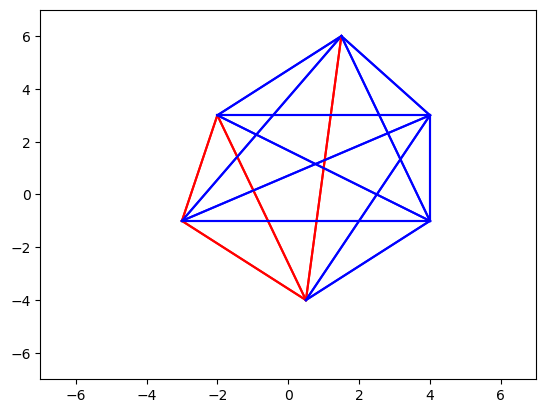

In [2]:
def life(i,j,A):
    icount = 0;
    jcount = 0;
    for n in range(6):
        if n != j and n != i:
            icount += A[i][n];
    for n in range(6):
        if n!= i and n!=i:
            jcount += A[j][n];
    if icount+jcount == 3 and A[i][j] == 0:
        return ['b',0];
    elif icount+ jcount == 3 and A[i][j] ==1:
        return ['r',1];
    elif icount+ jcount == 2 and A[i][j] ==1:
        return ['r',1];
    else:
        return ['b',0];
plt.ion();
fig, ax = plt.subplots();
X = np.array([(-3,-1), (-2, 3),(0.5 ,-4),(1.5,6),(4,3),(4,-1)]);
A = np.ones((6,6));

A = np.zeros((6,6));
A[0][1] = 1;
A[1][2] = 1;
A[0][2] = 1;
A[1][0]  = 1;
A[2][0] = 1;
A[2][3] =1; 
A[3][2] = 1;

A[2][1] =1;
Anext = A;
plot1 = [];
plot2 = [];

for t in range(5):
    ax.cla();
    ax.set_xlim(-7,7);
    ax.set_ylim(-7,7);
    
    n = len(X);
 

    for i in range(n):
        for j in range(n):
            if j != i:
                status,Anext[i][j] = life(i,j,A);
                x = [X[i][0],X[j][0]];
                y = [X[i][1], X[j][1]];
                ax.plot(x,y,status);
    A = Anext;
    fig.canvas.draw()
    fig.canvas.flush_events();
    display(fig);
    clear_output(wait = True);
    plt.pause(.25)

        
    
    

In [22]:
print(A)

[[0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [36]:
print(hist[4][:])

[]


In [14]:
print(B2hist[0][:])

IndexError: list index out of range

IndexError: list index out of range

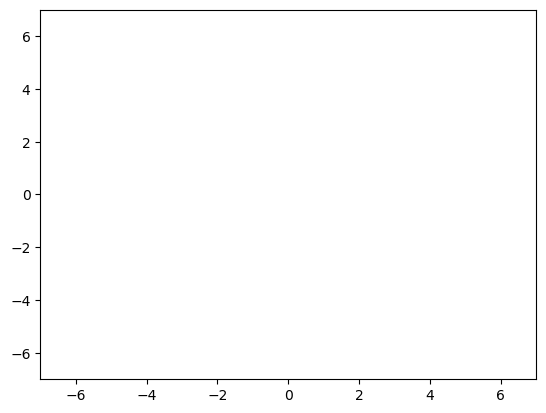

In [15]:
fig, ax = plt.subplots();
ax.cla();
ax.set_xlim(-7,7);
ax.set_ylim(-7,7);
for i in range(len(B2hist[0][:])):
    x = B2hist[0][i][:,0];
    y = B2hist[0][i][:,1];
    ax.scatter(x,y)
sx,sy = CPIH_Safepoint(n,B2hist[0][:]);
ax.fill(sx,sy)
#       y = safeY[i][:];
      #      ax.fill(x,y);

In [30]:
sx,sy = CPIH_Safepoint(n,B2hist[0][:]);

In [30]:
print(dist/5)

0.2690806449515544


In [31]:
print(step)

501
